## DUB survival analysis

This notebook is meant to analyze the correlation of deubiquitinating enzymes (DUBs) expression with overall survival in TCGA.

In [1]:
# import needed packages
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
from matplotlib_venn import venn2, venn2_circles
mpl.rcParams['pdf.fonttype'] = 42
import rpy2
%load_ext rpy2.ipython
os.environ['KMP_DUPLICATE_LIB_OK']='True'

The first step is to perform survival analysis using R.

In [210]:
%%R -o df,comparison_df
library(survival)

# prepare objects to support results 
df <- data.frame()
comparison_df <- data.frame()
pval.vec <- c()
ctype.vec <- c()

# perform cancer type specific analyses
for (f in list.files(path='data/dub_survival/', pattern='*.survival_input.txt')){
    ctype <- strsplit(f, "\\.")[[1]][1]   
    path <- paste('data/dub_survival/', ctype, '.survival_input.txt', sep='')
    
    # coxph regression
    data <- read.delim(path, sep='\t')
    ignore_cols <- c('PFI.time', 'PFI', 'ID')
    gene_ids <- c('ATXN3', 'BAP1', 'CYLD', 'TNFAIP3', 'UCHL1', 'UCHL5', 'USP19', 'USP28', 'USP34', 'USP48', 'USP9X')
    result_all <- coxph(Surv(OS.time, OS) ~ ., data=data[,!names(data) %in% ignore_cols])
    result_submodel <- coxph(Surv(OS.time, OS) ~ ., data=data[, !names(data) %in% c(ignore_cols, gene_ids)])
    comparison <- anova(result_all, result_submodel)

    # extract out result
    mycoefs <- as.data.frame(summary(result_all)$coefficients)
    mycoefs['feature'] <- row.names(mycoefs)
    mycoefs['cancer.type'] <- ctype
    
    # add results
    pval.vec <- c(pval.vec, comparison$"P(>|Chi|)"[2])
    ctype.vec <- c(ctype.vec, ctype)
    df <- rbind(df, mycoefs)
}

# evaluate whether it is significant
comparison_df <- data.frame(cancer.type=ctype.vec, pvalue=pval.vec)
comparison_df['qvalue'] <- p.adjust(comparison_df$pvalue, method='BH')

Process the survival associations from R to be in a format more amenble for plotting.

In [161]:
# keep only gene expression features for heatmap
tmp_df = df[~df['feature'].str.contains('subtype|purity')].copy()

# create heatmap of z-scores
plot_df = tmp_df.pivot(index='feature', columns='cancer.type', values='z')

# create an annotation of significance
tmp_df['significance'] = ''
tmp_df.loc[tmp_df['Pr(>|z|)']<0.05, 'significance'] = '*'
tmp_df.loc[tmp_df['Pr(>|z|)']<0.01, 'significance'] = '**'
tmp_df.loc[tmp_df['Pr(>|z|)']<0.001, 'significance'] = '***'
annot_df = tmp_df.pivot(index='feature', columns='cancer.type', values='significance')

# add -log10 qval col
comparison_df['-log10(qvalue)'] = -np.log10(comparison_df['qvalue'])
comparison_df.sort_values('pvalue', inplace=True)

Create a heatmap of all DUB gene expression associations with overall survival in TCGA.

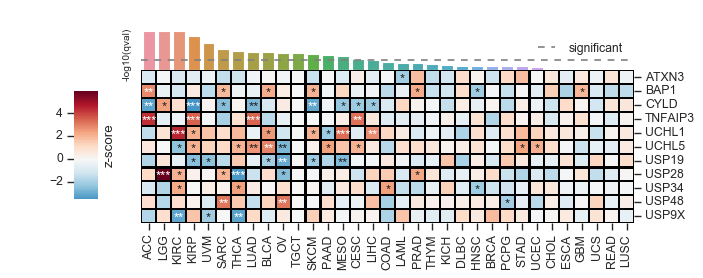

In [171]:
order = comparison_df['cancer.type'].tolist()
with sns.axes_style('ticks'):
    # creat heatmap
    g = sns.clustermap(
        plot_df[order], cmap='RdBu_r', center=0, 
        annot=annot_df[order], fmt='s', linewidth=1,
        linecolor='black', col_cluster=False, row_cluster=False
    )        
    # adjust heatmap annotation labels so that they are more centered
    for obj in g.ax_heatmap.get_children():
        if type(obj) is plt.Text:
            txtobj = obj
            x, y = txtobj.get_position()
            txtobj.set_position((x, y+0.2))
            txtobj.set(va='center')
    # adjust axis of heatmap
    g.ax_heatmap.set_xlabel('')
    g.ax_heatmap.set_ylabel('')
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    
    # create barplot for q-values of each cancer type
    ax = sns.barplot(order, comparison_df['-log10(qvalue)'], ax=g.ax_col_dendrogram)
    g.ax_col_dendrogram.axhline(-np.log10(0.05), ls='--', color='gray', label='significant')
    g.ax_col_dendrogram.legend(loc='upper right', frameon=False)
    g.ax_col_dendrogram.text(-1.75, 4.5, '-log10(qval)', rotation=90, size=9)
    
    # adjust colorbar
    plt.gcf().set_size_inches(10, 3)
    g.cax.set_position([.2, .2, .03, .45])
    g.cax.set_ylabel('z-score')
    g.cax.yaxis.set_ticks_position('left')

    # save results
    g.savefig('figures/dub_survival.pdf')
